In [1]:
import pymysql
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
import os

host_name = os.getenv('HOST_NAME')
passwd = os.getenv('AWS_PASSWORD')
user='group2'
database='group2db'

In [3]:
con = pymysql.connect(host=host_name,user=user,passwd=passwd,db=database)


In [4]:
# Connecting AWS mysql Database
db = pymysql.connect(host_name, user, passwd, database)

In [5]:
cursor = db.cursor()

In [6]:
# Reading sql table into pandas DataFrame
tweet_df = pd.read_sql_query('''select * from tweets_locations2''', con)

In [7]:
tweet_df

,tweet_id,tweet,location
0,1,RT @laggy_mads: Y’all got me fucked up if you ...,Oregon
1,2,I've been trying to sign my 102-year-old grand...,New York
2,3,Pro-life my ass.????,Colorado
3,4,RT @ImmunoFever: Every single vaccination plac...,Arizona
4,5,RT @WSJ: U.S. officials will suggest anyone ov...,New York
...,...,...,...
2972,2973,Whatever they gotta do to get this stuff in ou...,Florida
2973,2974,In case you missed it: The recording of DHW's ...,Idaho
2974,2975,New Jersey residents ages 65 and older will be...,New Jersey
2975,2976,The news I’ve been waiting for!,New York


In [8]:
tweet_df = tweet_df.drop(columns=['tweet_id'], axis=1)

In [9]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     2977 non-null   object
 1   location  2977 non-null   object
dtypes: object(2)
memory usage: 46.6+ KB


In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
#  Function to clean the tweets
def remove_punc(message):
    Test_punc_removed = [ char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    return Test_punc_removed_join
tweet_df['tweet'] = tweet_df['tweet'].apply(remove_punc)
tweet_df

,tweet,location
0,RT laggymads Y’all got me fucked up if you thi...,Oregon
1,Ive been trying to sign my 102yearold grandfat...,New York
2,Prolife my ass,Colorado
3,RT ImmunoFever Every single vaccination place ...,Arizona
4,RT WSJ US officials will suggest anyone over 6...,New York
...,...,...
2972,Whatever they gotta do to get this stuff in ou...,Florida
2973,In case you missed it The recording of DHWs se...,Idaho
2974,New Jersey residents ages 65 and older will be...,New Jersey
2975,The news I’ve been waiting for,New York


In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','tweet','today','week','year', 'https','httpstco', 'rt', 'RT'])

In [13]:
# Remove stopwords and remove short words (less than 2 characters)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) >= 2:
            result.append(token)
    return result
tweet_df['tweet'] = tweet_df['tweet'].apply(preprocess).apply(lambda x: " ".join(x))
tweet_df

,tweet,location
0,laggymads got fucked think getting covid vaccine,Oregon
1,ive trying sign yearold grandfather get covid ...,New York
2,prolife ass,Colorado
3,immunofever every single vaccination place nee...,Arizona
4,wsj us officials suggest anyone preexisting co...,New York
...,...,...
2972,whatever gotta get stuff veins huh covidvaccin...,Florida
2973,case missed recording dhws second weekly media...,Idaho
2974,new jersey residents ages older eligible covid...,New Jersey
2975,news waiting,New York


In [15]:
# Function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Creating two new columns Subjectivity, Polarity
tweet_df['Subjectivity'] = tweet_df['tweet'].apply(getSubjectivity)
tweet_df['Polarity'] = tweet_df['tweet'].apply(getPolarity)

In [16]:
tweet_df

,tweet,location,Subjectivity,Polarity
0,laggymads got fucked think getting covid vaccine,Oregon,0.700000,-0.600000
1,ive trying sign yearold grandfather get covid ...,New York,0.000000,0.000000
2,prolife ass,Colorado,0.000000,0.000000
3,immunofever every single vaccination place nee...,Arizona,0.416667,0.238095
4,wsj us officials suggest anyone preexisting co...,New York,0.800000,0.400000
...,...,...,...,...
2972,whatever gotta get stuff veins huh covidvaccin...,Florida,0.000000,0.000000
2973,case missed recording dhws second weekly media...,Idaho,0.000000,0.000000
2974,new jersey residents ages older eligible covid...,New Jersey,0.393939,0.151515
2975,news waiting,New York,0.000000,0.000000


In [18]:
df_pos = tweet_df[tweet_df['Polarity'] > 0.0]
df_neg = tweet_df[tweet_df['Polarity'] < 0.0]
df_nut = tweet_df[tweet_df['Polarity'] == 0.0]
print("Number of Positive Tweets", len(df_pos))
print("Number of Negative Tweets", len(df_neg))
print("number of Nutral Tweets", len(df_nut))

Number of Positive Tweets 1208
Number of Negative Tweets 503
number of Nutral Tweets 1266


In [20]:
# Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return "Neutral"
    else:
        return 'Positive'

tweet_df['Analysis'] = tweet_df['Polarity'].apply(getAnalysis)
tweet_df

,tweet,location,Subjectivity,Polarity,Analysis
0,laggymads got fucked think getting covid vaccine,Oregon,0.700000,-0.600000,Negative
1,ive trying sign yearold grandfather get covid ...,New York,0.000000,0.000000,Neutral
2,prolife ass,Colorado,0.000000,0.000000,Neutral
3,immunofever every single vaccination place nee...,Arizona,0.416667,0.238095,Positive
4,wsj us officials suggest anyone preexisting co...,New York,0.800000,0.400000,Positive
...,...,...,...,...,...
2972,whatever gotta get stuff veins huh covidvaccin...,Florida,0.000000,0.000000,Neutral
2973,case missed recording dhws second weekly media...,Idaho,0.000000,0.000000,Neutral
2974,new jersey residents ages older eligible covid...,New Jersey,0.393939,0.151515,Positive
2975,news waiting,New York,0.000000,0.000000,Neutral


Text(0.5, 1.0, 'Twitter Sentiment Analysis')

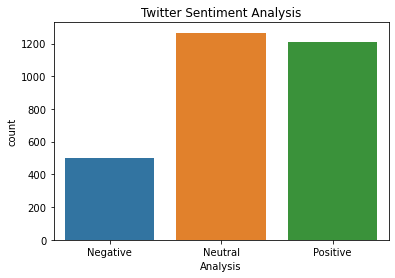

In [26]:
sns.countplot(tweet_df['Analysis']).set_title('Twitter Sentiment Analysis')

<Figure size 1440x1440 with 0 Axes>

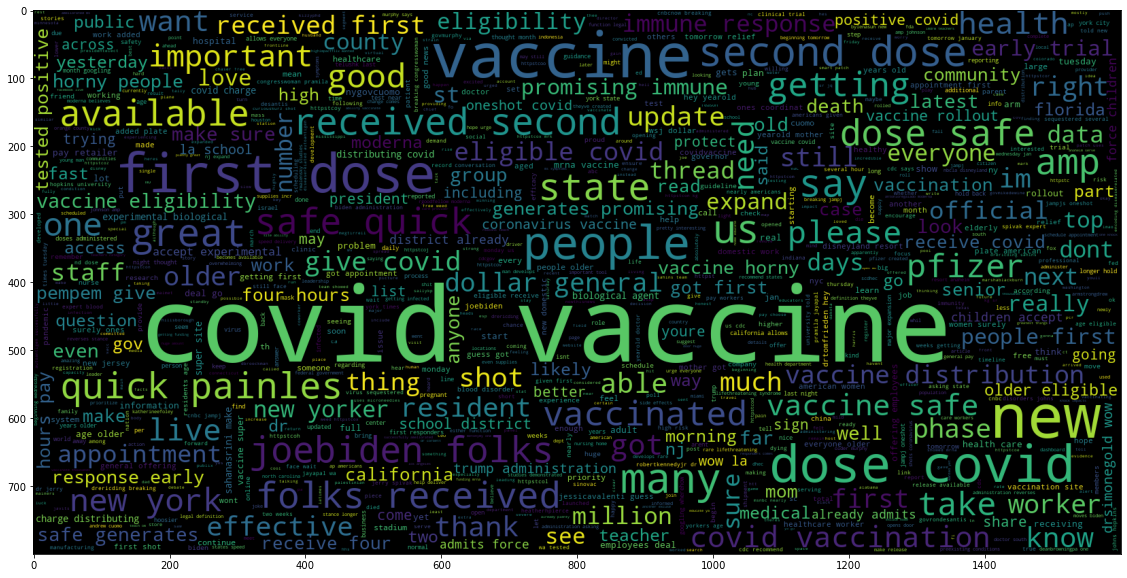

In [27]:
#positive sentiment
plt.figure(figsize= (20, 20))
wc = WordCloud(max_words = 900, width = 1600, height = 800).generate(" ".join(tweet_df[tweet_df['Polarity'] > 0.0]['tweet']))
plt.figure(figsize=(20, 10), facecolor='white', edgecolor='blue')

plt.imshow(wc)

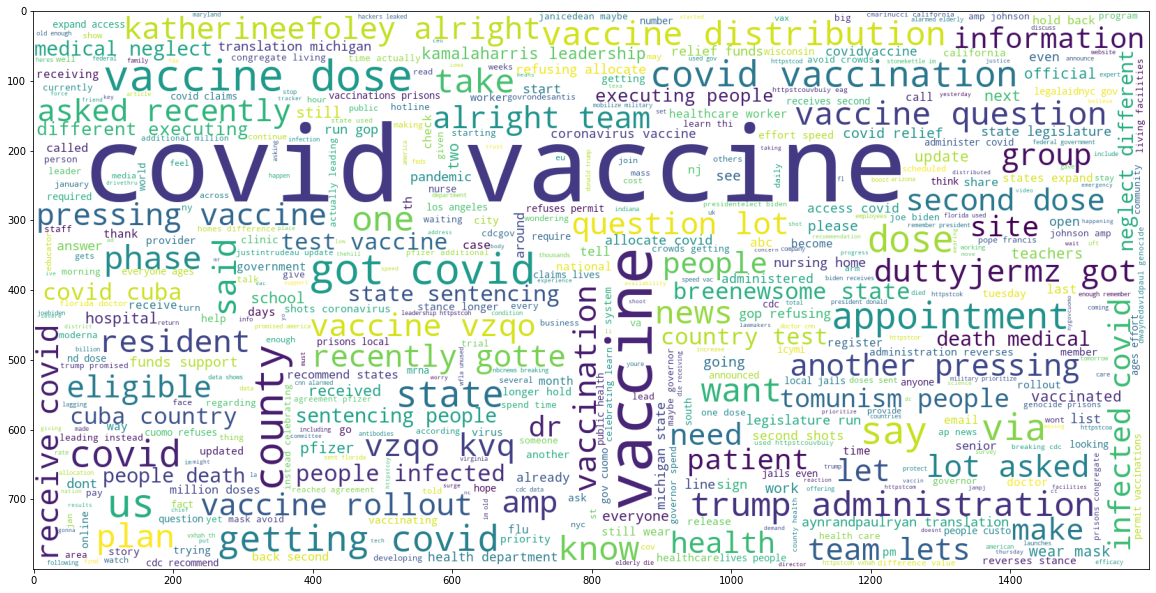

In [28]:
# nutral sentiment word cloud

plt.figure(figsize= (20, 20))
wc = WordCloud(background_color='white', max_words = 500, width = 1600, height = 800).generate(" ".join(tweet_df[tweet_df['Polarity'] == 0.0]['tweet']))
plt.imshow(wc)

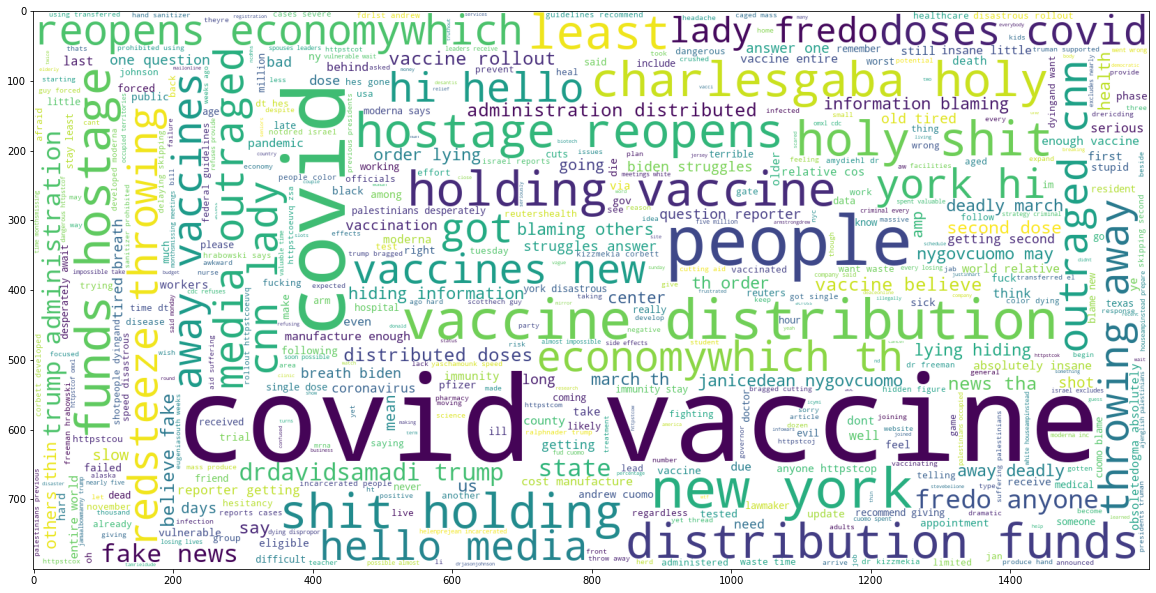

In [29]:
# negative sentiment word cloud

plt.figure(figsize= (20, 20))
wc = WordCloud(background_color='white', max_words = 500, width = 1600, height = 800).generate(" ".join(tweet_df[tweet_df['Polarity'] < 0.0]['tweet']))
plt.imshow(wc)

In [30]:
list_of_words = []

for i in tweet_df['tweet']:
    for j in i:
        list_of_words.append(j)

In [32]:
total_words = len(list(set(list_of_words)))
total_words

42

In [33]:
# split the data into test and train

X = tweet_df['tweet']
y = tweet_df['Polarity']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [34]:
X_train.shape

(2679,)

In [35]:
X_test.shape

(298,)

In [36]:
# create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)

In [37]:
print('The encoding for document\n', X_train[1:2], 'is:', train_sequences[1])

The encoding for document
 2769    vaccines chance redeem failures us coronavirus...
Name: tweet, dtype: object is: [9, 18]


In [38]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen=29)
padded_test = pad_sequences(test_sequences, maxlen=29)

In [39]:
for i, doc in enumerate(padded_train[:3]):
    print('The padded encoding for document:',  i+1, 'is', doc)

The padded encoding for document: 1 is [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 32  8 36]
The padded encoding for document: 2 is [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  9 18]
The padded encoding for document: 3 is [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 20]


In [40]:
y_train

2877    0.000000
2769   -0.500000
589    -0.383333
2710    0.500000
1753    0.000000
          ...   
262     0.250000
2890    0.000000
850     0.000000
1477   -0.400000
195     0.500000
Name: Polarity, Length: 2679, dtype: float64

In [41]:
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [42]:
y_train_cat.shape

(2679, 2)

In [43]:
y_test_cat.shape

(298, 2)

In [44]:
y_train_cat

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [45]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen=15)
padded_test = pad_sequences(test_sequences, maxlen=15)

In [46]:
for i, doc in enumerate(padded_train[:3]):
    print('The padded encoding for document:',  i+1, 'is', doc)

The padded encoding for document: 1 is [ 0  0  0  0  0  0  0  0  0  0  0  0 32  8 36]
The padded encoding for document: 2 is [ 0  0  0  0  0  0  0  0  0  0  0  0  0  9 18]
The padded encoding for document: 3 is [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 20]


In [47]:
y_train

2877    0.000000
2769   -0.500000
589    -0.383333
2710    0.500000
1753    0.000000
          ...   
262     0.250000
2890    0.000000
850     0.000000
1477   -0.400000
195     0.500000
Name: Polarity, Length: 2679, dtype: float64

In [48]:
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [49]:
y_train_cat.shape

(2679, 2)

In [50]:
y_test_cat.shape

(298, 2)

In [51]:
y_train_cat

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [52]:
# Sequential model
model = Sequential()
model.add(Embedding(total_words, output_dim = 512))

model.add(LSTM(256))

model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         21504     
_________________________________________________________________
lstm (LSTM)                  (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 842,114
Trainable params: 842,114
Non-trainable params: 0
_________________________________________________________________


In [53]:

# train the model
model.fit(padded_train, y_train_cat, batch_size=32, validation_split=0.2, epochs = 2)

Epoch 1/2
67/67 [==============================] - 8s 90ms/step - loss: 0.1766 - acc: 0.9736 - val_loss: 0.0414 - val_acc: 0.9944
Epoch 2/2
67/67 [==============================] - 6s 87ms/step - loss: 0.0540 - acc: 0.9917 - val_loss: 0.0352 - val_acc: 0.9944


In [54]:
# Sequential model
model = Sequential()
model.add(Embedding(total_words, output_dim = 1000))

model.add(LSTM(256))

model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 1000)        42000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               1287168   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 1,362,322
Trainable params: 1,362,322
Non-trainable params: 0
_________________________________________________________________


In [55]:
# train the model
model.fit(padded_train, y_train_cat, batch_size=32, validation_split=0.2, epochs = 2)

Epoch 1/2
67/67 [==============================] - 11s 137ms/step - loss: 0.1483 - acc: 0.9219 - val_loss: 0.0351 - val_acc: 0.9944
Epoch 2/2
67/67 [==============================] - 8s 127ms/step - loss: 0.0436 - acc: 0.9935 - val_loss: 0.0361 - val_acc: 0.9944


In [56]:
# make prediction
pred = model.predict(padded_test)

In [57]:
# make prediction
# argmax finds the argument that gives the maximum value to find the class with the highest probability(predictions).

prediction = []
for i in pred:
    prediction.append(np.argmax(i))

In [58]:
# Prediction
# list containing original values
original = []
for i in y_test_cat:
    original.append(np.argmax(i))

In [59]:
# original

In [60]:
# accuracy score on text data
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, prediction)

In [61]:
accuracy

0.9966442953020134

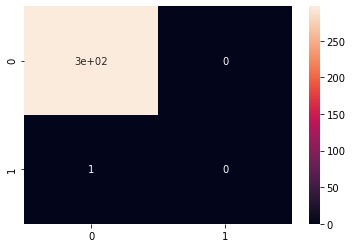

In [62]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)